<a href="https://colab.research.google.com/github/Mehrab-Tanjim/Eluvio_DS_Challenge/blob/main/Eluvio_DS_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Table of Contents
* [Loading Large Dataset](#p1)
* [Initial Analysis](#p2)
* [Formulating a Predictive Task w/ a Business Objective](#p3)
* [Machine Learning Pipeline](#p4)
* [Model Deployment and Prediction](#p5)
* [Conclusion](#p6)


## <a name="p1"></a>Loading Large Dataset

### Importing standard libraries

In [ ]:
import matplotlib.pylab as plt
from datetime import datetime
import pandas as pd
import numpy as np
import gdown
import seaborn as sns
sns.set_theme()
import warnings
warnings.filterwarnings('ignore')
from random import shuffle

Our first assumption is the dataset is large and thus cannot be loaded into memory. Thus we need to read it by chunks. Fortunately, there are scalable and efficient libraries available for analyzing large dataset (e.g. PySpark, Dask, etc.). Before using them though, lets assume the dataset is available in our local path.


### Downloading the dataset

In [ ]:
url = 'https://drive.google.com/uc?id=15X00ZWBjla7qGOIW33j8865QdF89IyAk'
output = 'Eluvio_DS_challenge.csv'

In [ ]:
gdown.download(url, output, quiet=False) 

Downloading...
From: https://drive.google.com/uc?id=15X00ZWBjla7qGOIW33j8865QdF89IyAk
To: /content/Eluvio_DS_challenge.csv
82.2MB [00:00, 156MB/s]


'Eluvio_DS_challenge.csv'

### Using Dask framework

In this notebook, we will use one of the large-scale data analysis libraries, namely Dask, which allows distributed computing like PySpark and has similar *Pandas dataframe* commands. It also integrates nicely with other python machine learning libraries such scikit-learn, pytorch, etc. 

In [ ]:
!pip -q install distributed dask[complete] dask-ml[complete] --upgrade

In [ ]:
import dask.dataframe as dd

In [ ]:
filename = 'Eluvio_DS_challenge.csv'
ddf = dd.read_csv(filename, blocksize=25e6) #assuming the dataset is large, read 25 MB block at a time

In [ ]:
ddf.head(10)

,time_created,date_created,up_votes,down_votes,title,over_18,author,category
0,1201232046,2008-01-25,3,0,Scores killed in Pakistan clashes,False,polar,worldnews
1,1201232075,2008-01-25,2,0,Japan resumes refuelling mission,False,polar,worldnews
2,1201232523,2008-01-25,3,0,US presses Egypt on Gaza border,False,polar,worldnews
3,1201233290,2008-01-25,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews
4,1201274720,2008-01-25,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews
5,1201287889,2008-01-25,15,0,Hay presto! Farmer unveils the illegal mock-...,False,Armagedonovich,worldnews
6,1201289438,2008-01-25,5,0,"Strikes, Protests and Gridlock at the Poland-U...",False,Clythos,worldnews
7,1201536662,2008-01-28,0,0,The U.N. Mismanagement Program,False,Moldavite,worldnews
8,1201558396,2008-01-28,4,0,Nicolas Sarkozy threatens to sue Ryanair,False,Moldavite,worldnews
9,1201635869,2008-01-29,3,0,US plans for missile shields in Polish town me...,False,JoeyRamone63,worldnews


In [ ]:
numerical_descriptors = ddf.describe().compute()

In [ ]:
numerical_descriptors

,time_created,up_votes,down_votes
count,5.092360e+05,509236.000000,509236.0
mean,1.380240e+09,112.236283,0.0
std,7.090436e+07,541.694675,0.0
min,1.201232e+09,0.000000,0.0
25%,1.330737e+09,2.000000,0.0
50%,1.385386e+09,5.000000,0.0
75%,1.424695e+09,20.000000,0.0
max,1.479817e+09,21253.000000,0.0


## <a name="p2"></a>Initial Analysis

### Uniqueness

The dataset seems to contain following features: ***time_created, date_created, up_votes, down_votes, title, over_18, author, category***. A brief preview of the dataset implies that the each record contains the title of a news article along with its author and some metadata such as date posted, up/down votes it received, and whether it is intended for mature audience. It also seems that there are no ***down_votes*** and all records tend to have same values for ***over_18 and category***. Lets check for uniqueness to test this.



In [ ]:
ddf['over_18'].unique().compute()

0    False
1     True
Name: over_18, dtype: bool

In [ ]:
ddf[ddf['over_18']==True].shape[0].compute()

320

In [ ]:
ddf[ddf['over_18']==False].shape[0].compute()

508916

In [ ]:
ddf['category'].unique().compute()

0    worldnews
Name: category, dtype: object

It seems all records belong to ***worldnews*** category, and very few records are intended for mature audience. Similarly, we can check if our titles are unique. Practically speaking, the titles should be unique but if there are redundancies, it might be worth looking into those examples before discarding them as duplicates.

In [ ]:
ddf_filter = ddf['title'].value_counts().map(lambda x: x > 1)
ddf_dup_title = ddf[ddf["title"].isin(list(ddf_filter[ddf_filter].index))]

In [ ]:
ddf_dup_title.head(10)

,time_created,date_created,up_votes,down_votes,title,over_18,author,category
155,1202885193,2008-02-13,1,0,Australia apologizes to Aborigines,False,emoticon,worldnews
156,1202892267,2008-02-13,2,0,Australia apologizes to Aborigines,False,stonecold,worldnews
442,1203871087,2008-02-24,0,0,Pakistan Blocks YouTube,False,twolf1,worldnews
453,1203893169,2008-02-24,0,0,Pakistan Blocks YouTube,False,BravoLima,worldnews
589,1204210343,2008-02-28,7,0,China considers ending one-child policy,False,stubble,worldnews
623,1204297833,2008-02-29,91,0,China considers ending one-child policy,False,rjonesx,worldnews
1071,1205216420,2008-03-11,2,0,China detains dozens of Tibetan monks after pr...,False,markansoul,worldnews
1072,1205217150,2008-03-11,2,0,China detains dozens of Tibetan monks after pr...,False,ramblasos,worldnews
1244,1205537286,2008-03-14,23,0,Chavez Says US Can Shove Terror List,False,pianist,worldnews
1266,1205597660,2008-03-15,5,0,Chavez Says US Can Shove Terror List,False,cptnlazer,worldnews


In [ ]:
len(ddf_dup_title.title.compute())

16241

In [ ]:
len(ddf_dup_title.title.drop_duplicates().compute())

7725

Seems like the titles are not unique. Further inspection into the a preview of the duplicate title entries reveal that they have different authors, times and up votes. This suggests that the record in our dataset mimics the reddit post mechanism, where users can share the original post and its up votes can either increase or decrease depending on other factors. Let's do some further analysis before coming up with a predictive task that may have some business use-cases.

### Up votes analysis

One of the numerical column of the dataset is up votes, and this can be used as a depenedable variable in predictive modeling tasks. So, we will do some analysis on up votes based on other columns in our dataset.

#### Visualizing up votes over time

As the dataset is assumed to be large, we can sample a fraction of the dataset for visualization purpose. Alternatively, we can also use large-scale visualization libraries such as *Datashader*. But in this notebook, we will use the former technique and sample 10% of the data (this should vary depending on the dataset size).

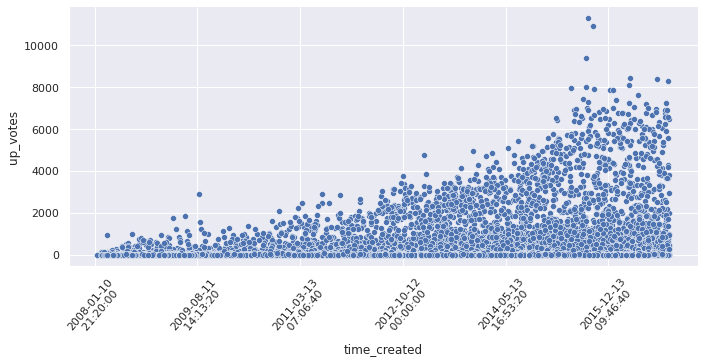

In [ ]:
g= sns.pairplot(x_vars='time_created', y_vars='up_votes', data=ddf.sample(frac=0.1).compute())
g.fig.set_size_inches(15,5)
ax = plt.gca()
ax.set_xticklabels([datetime.utcfromtimestamp(tm).strftime('%Y-%m-%d\n %H:%M:%S') for tm in ax.get_xticks()],
 rotation=50)
plt.show()

This reveals an interesting pattern. It shows, as time progresses, the maximum up vote a post receives also increases. This makes sense for a web-based service, such as reddit, because **the platform over time can gain more active users and thus posts in later times can receive more user's votes than posts in earlier times.** Although there is no information to active users against timestamp, we can get a sense this is the case by analyzing unique number of authors in yearly fashion.

In [ ]:
ddf['year'] = ddf.apply(lambda row: datetime.utcfromtimestamp(row['time_created']).strftime("%Y"), axis=1, meta=int)

In [ ]:
unique_authors_yearly = ddf.drop_duplicates(subset=['author']).groupby('year')['author'].count().compute()

Text(0, 0.5, 'Total')

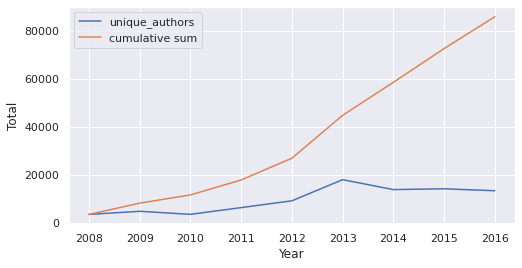

In [ ]:
plt.figure(figsize=(8,4))

plt.rcParams.update({'font.size': 10})
plt.plot(unique_authors_yearly.index, unique_authors_yearly.values)

plt.plot(unique_authors_yearly.index, unique_authors_yearly.cumsum().values)
plt.legend(['unique_authors', 'cumulative sum'])
plt.xlabel('Year')
plt.ylabel('Total')

This graph tells us that each year number of unique author (from the beginning of the time) increases in almost in a linear fashion. Based on this, we can make an assumption that number of users also increases in the platform which can explain the high number of up votes in recent years. 

If we want to make a predictive model of up votes, we need to take this information in consideration to encounter the high discrepencies. We can follow one of the following ways:
1. Normalize the vote counts: we can normalize the vote counts based on time period so that the highest up voted title in earlier times can stay on top in later times as well.

2. Log transform: As the up votes vary widely, we can log tranform the vote counts. This however wil not guarantee that eariler top rated titles can stay on top.

In the following, we will do some analysis on both transformation of the up votes. But first, let's perform the transformation.

In [ ]:
# This pandas command wont work on dask dataframe 
# ddf.groupby('year')['up_votes'].transform(lambda x: (x - x.mean()) / x.std())
# so we will do a little work around
z_info_group = ddf.groupby('year').agg({'up_votes': ['mean', 'std']}).compute()

In [ ]:
ddf['normalized_ups'] = ddf.apply(lambda row: (row['up_votes']-z_info_group['up_votes']['mean'][row['year']])/z_info_group['up_votes']['std'][row['year']], axis=1, meta=float)

In [ ]:
ddf = ddf.persist() #persis the transformation across partition

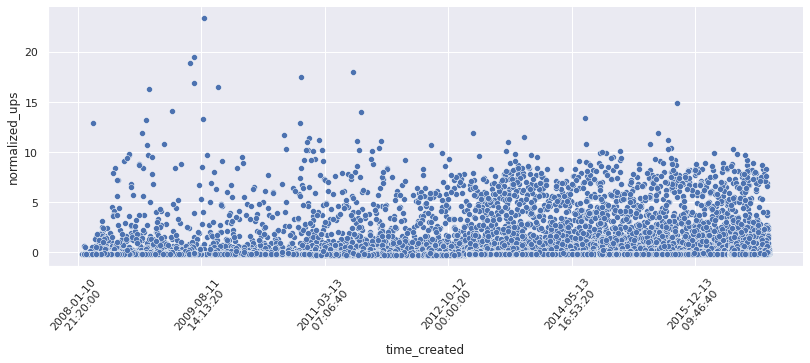

In [ ]:
g= sns.pairplot(x_vars='time_created', y_vars='normalized_ups', data=ddf.sample(frac=0.1).compute())
g.fig.set_size_inches(15,5)
ax = plt.gca()
ax.set_xticklabels([datetime.utcfromtimestamp(tm).strftime('%Y-%m-%d\n %H:%M:%S') for tm in ax.get_xticks()],
 rotation=50)
plt.show()

In [ ]:
ddf['log_ups'] = ddf.apply(lambda row: np.log1p(row['up_votes']), axis=1, meta=float)

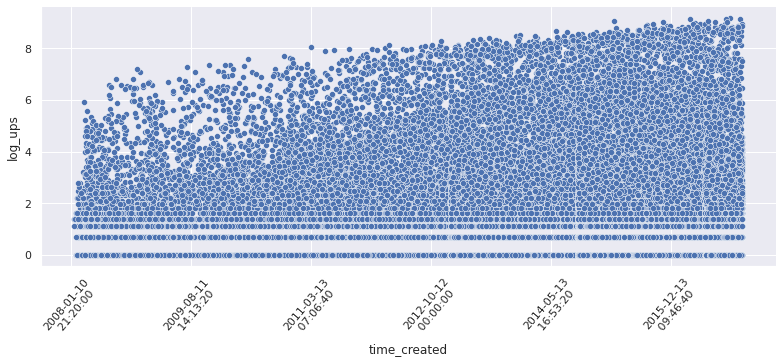

In [ ]:
g= sns.pairplot(x_vars='time_created', y_vars='log_ups', data=ddf.sample(frac=0.1).compute())
g.fig.set_size_inches(15,5)
ax = plt.gca()
ax.set_xticklabels([datetime.utcfromtimestamp(tm).strftime('%Y-%m-%d\n %H:%M:%S') for tm in ax.get_xticks()],
 rotation=50)
plt.show()

Both of plots show that the votes are now more uniformly spread across time.

Text(0.5, 1.0, 'Distribution of up votes in $log$ scale')

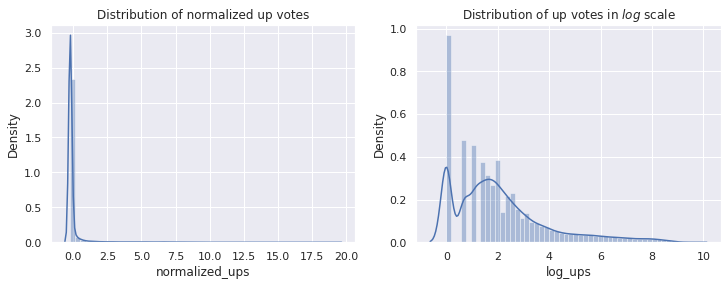

In [ ]:
f= plt.figure(figsize=(12,4))

ax=f.add_subplot(121)
plt.rcParams.update({'font.size': 10})
sns.distplot(ddf.sample(frac=0.1)['normalized_ups'],bins=50,color='b',ax=ax)
ax.set_title('Distribution of normalized up votes')

ax=f.add_subplot(122)
plt.rcParams.update({'font.size': 10})
sns.distplot(ddf.sample(frac=0.1)['log_ups'],bins=50,color='b',ax=ax)
ax.set_title('Distribution of up votes in $log$ scale')


It seems we have a high skew in normalized up votes whether log transformation is relatively spread. We can further decide which transformation to use by observing the correlation matrix between useful features and the variables in question

#### Effect of common text features

Intuitively speaking, a post with informative and relvent title should be well received by the community and thus can get high upvotes. Similarly, non-informative and irrelevent titled posts are more vulnerable to down votes. Since there are no records with down votes in our dataset, we can focus entirely on up vote counts which can be used a measurement of popularity. The common features of a text are its length and number of unique words. Let's observe their impact on vote counts.

In [ ]:
ddf['text_length'] = ddf.apply(lambda row: len(row['title']), axis=1, meta=int)

In [ ]:
ddf['unique_words'] = ddf.apply(lambda row: len(set(row['title'])), axis=1, meta=int)

In [ ]:
ddf = ddf.persist()

In [ ]:
ddf.nlargest(n=10, columns=['up_votes'])[['text_length','unique_words']].compute()

,text_length,unique_words
69179,289,30
83394,139,26
142797,277,30
83297,243,27
82231,98,22
141788,100,24
89194,92,22
82473,188,30
36493,225,28
80209,122,26


In [ ]:
ddf.nsmallest(n=10, columns=['up_votes'])[['text_length','unique_words']].compute()

,text_length,unique_words
7,30,18
18,73,20
22,55,23
26,54,21
32,38,19
33,79,28
44,82,26
46,69,23
47,32,17
56,65,22


This small fraction indicates there might be some correlation between these features and up votes. We can also calculate their correlation with the transformed variables.

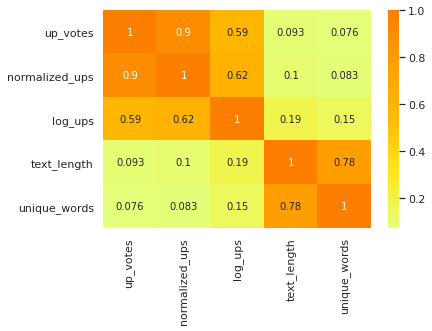

In [ ]:
corr = ddf.sample(frac=0.25).compute()[['up_votes','normalized_ups','log_ups','text_length','unique_words']].corr()
sns.heatmap(corr, cmap = 'Wistia', annot= True)

It seems both text length and number of unique words have relatively higher positive correlation with log ups than raw votes and normalized ups. This is helpful because this gives us a good idea of a variable to predict and which transformation to use on the dependent variable. Although notice that the correlation values are **small** (0.19 and 0.15 respectively). So, we should experiment on other useful text features such as ***TF-IDF vectors, Count Vectors, Sentence Embedding***, etc. For now, let's try to find other useful features other than text and use log transformation on up votes.

#### Effect of time of the post

To observe the effect of the time on post, we can extract the hour and week information from the unix timestamp.

In [ ]:
ddf['hours'] = ddf.apply(lambda row: datetime.utcfromtimestamp(row['time_created']).hour, axis=1, meta=int)

In [ ]:
ddf['weekday'] = ddf.apply(lambda row: datetime.utcfromtimestamp(row['time_created']).strftime("%A"), axis=1, meta=str)

In [ ]:
ddf = ddf.persist()

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

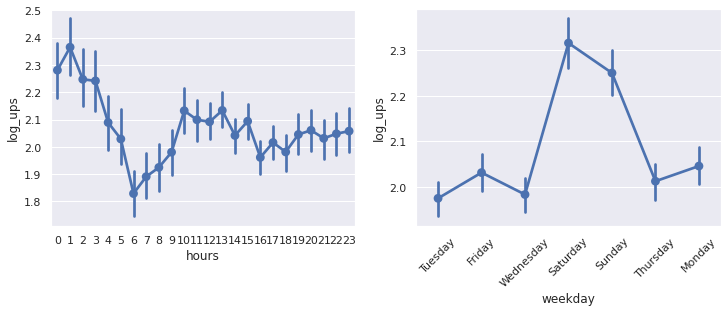

In [ ]:
f= plt.figure(figsize=(12,4))

ax=f.add_subplot(121)
plt.rcParams.update({'font.size': 10})
sns.pointplot(x = 'hours', y = 'log_ups', data = ddf.sample(frac=0.1).compute(), ax=ax)

ax=f.add_subplot(122)
plt.rcParams.update({'font.size': 10})
sns.pointplot(x = 'weekday', y = 'log_ups', data = ddf.sample(frac=0.1).compute(), ax=ax)
plt.xticks(rotation = 45)

These plots reveal common sensical impact of time over votes. The first plot shows that people are not that active during after 2am and before 7 am, and so number of votes decline that time. Most of the people tend to check during lunch time (11am - 1pm) and before going back to sleep (9am - 2am). The second plot shows people tend to vote more on weekends (Saturday and Sunday). Notice, the changes of log_ups values for both features are **small**.

#### Effect of over 18 posts

Finally we can draw a plot to see the impact of over_18 variable. The following violin plot shows the distributions of up votes are quite different between the two values. However, as the number of over 18 posts are very few, its contribution might be very little as well. Nonetheless, we can use this feature for predictive modeling task.

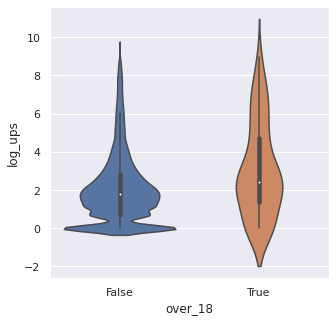

In [ ]:
plt.figure(figsize=(5, 5))
plt.rcParams.update({'font.size': 10})
sns.violinplot(x = 'over_18', y = 'log_ups', data = ddf.sample(frac=0.25).compute())

## <a name="p3"></a> Formulating a Predictive Task w/ a Business Objective

Based on our inital analysis, we are now in a position to formulate predictive tasks. Here are some of the tasks we can do with the dataset:

1. **Classify resubmissions**: As there are duplicate titles with different up_votes (which is an indication of resubmissions), we can predict whether a resubmission will get higher votes than the original.

2. **Predict up-votes**: We can predict how many votes a post can get based on text of the title, time of the post, and whether it is for mature audience or not.

While formulating the task, we also have to think about a good business use-case. In terms of business use-case, Task 2 is more appropriate. Here is why: for a web-based service, like reddit, there will be new posts each day, and they might want to know which posts are predicted to get high number of up-votes. By doing so, it can increase the click-through-rates or views counts, which can, in turn, increase the revenue of a web-based service. Task 1 can only predict which post can get higher votes after it is resubmitted while Task 2 can do so for original posts which is a much stricter requirement for web-platforms. Another reason is there might not be a lot of resubmissions (e.g. in this dataset there were only 8516 resubmissions from 7725 original posts), and thus Task 2 has lower potential of generating revenue.

So, based on the business-case, we will select the task of **predicting up-votes as our predictive machine learning task**.

### Designing Train/Val/Test Splits

Our business use case requires us to predict future posts. For example, we may want to predict which posts will be trending next one or two weeks based on previous posts. Thus for testing and validation purposes, we can isolate the most recent posts. In this notebook, we will consider posts during last two weeks as test set, and last two weeks before that as validation set. Before doing so, lets drop the duplicates posts and only keep the original posts.

In [ ]:
ddf_dropped = ddf.sort_values('time_created').drop_duplicates(subset='title', keep='first')

In [ ]:
ddf_dropped = ddf_dropped.persist()

In [ ]:
latest_time = int(ddf_dropped.nlargest(1, columns=['time_created']).time_created.compute())

In [ ]:
val_dataset = ddf_dropped[(ddf_dropped['time_created']<=latest_time-1*15*24*60*60)&(ddf_dropped['time_created']>=(latest_time-(2*15*24*60*60)))]

In [ ]:
test_dataset = ddf_dropped[(ddf_dropped['time_created']<=latest_time)&(ddf_dropped['time_created']>=(latest_time-(1*15*24*60*60)))]

For training dataset, note our earlier analysis of up-votes over time revealed that there are anomalies of votes in different times. So, we may also want to use a certain portion of the remaining dataset for training. As log transformations of up votes have more correlation with features (from correlation matrix), we should use that as depended variable and select a cut off point based on the plot of log_ups vs time. Based on the plot, **we will use most recent 4 years of data**. Before we train on full dataset though, lets use a small segment (most recent 6 months in this case) to find useful text features quickly. 

In [ ]:
train_dataset = ddf_dropped[(ddf_dropped['time_created']<=latest_time-2*15*24*60*60)&(ddf_dropped['time_created']>=(latest_time-(2*15*24*60*60+6*30*24*60*60)))]

In [ ]:
train_dataset, val_dataset, test_dataset = train_dataset.persist(), val_dataset.persist(), test_dataset.persist()

## <a name="p4"></a> Machine Learning Pipeline

### Preprocessing the dataset

As we have both categorical and numerical features, we have to transform them properly, that is convert categorical features to one hot encoding and scaling the numerical features. 

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

In [ ]:
scaler = StandardScaler().fit(train_dataset[['text_length', 'unique_words']])
categories = [list(range(24)), ['Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], [False, True]]
one_hot_encoder = OneHotEncoder(drop='first', sparse=True, categories=categories).fit(train_dataset[['hours','weekday','over_18']])

### Building a custom data iterator

As our dataset is assumed to be larger than memory, we will need to design an iterator that can create a batch of dataset from the rows of the Dask dataframe object and perform the necessary transformations.

In [ ]:
from scipy.sparse import csr_matrix, vstack, hstack
class CustomDataset():

    def __init__(self, dataset, y_var, text_vectorizer, one_hot_encoder, scaler, batch_size, text_features=True, cat_feature=True, num_feature=True):
        self.dataset = dataset
        self.y_var = y_var
        self.batch_size = batch_size
        self.one_hot_encoder = one_hot_encoder
        self.text_vectorizer = text_vectorizer
        self.scaler = scaler
        self.text_features = text_features
        self.cat_feature = cat_feature
        self.num_feature = num_feature

    def __len__(self):
        return len(self.dataset)//self.batch_size

    def __iter__(self):
        'Generates batches of examples'
        count = 0
        features_batch = None
        y_batch = []

        for row in self.dataset.iterrows():
            try:
              y = row[1][self.y_var]

              title = row[1]['title']

              features = None
              
              if self.text_features:
                  for vectorizer in self.text_vectorizer:
                      try:
                          text_features = vectorizer.transform([title])  
                      except:     
                          text_features = csr_matrix(vectorizer(title))

                      if features is None:
                          features = text_features
                      else: 
                          features = hstack([features, text_features])

              if self.cat_feature:
                  categorical_features = self.one_hot_encoder.transform([[row[1]['hours'], row[1]['weekday'], row[1]['over_18']]])
                  if features is None:
                      features = categorical_features
                  else:
                      features = hstack([features, categorical_features])

              if self.num_feature:
                  numerical_features = csr_matrix(self.scaler.transform([[row[1]['text_length'],row[1]['unique_words']]])[0])
                  if features is None:
                      features = numerical_features
                  else:
                      features = hstack([features, numerical_features])
              
            except:
                continue
            
            count +=1

            if features_batch is None:
                features_batch = features
            else:
                features_batch = vstack([features_batch,features])
            
            y_batch.append(y)
            
            if count == self.batch_size:
              count = 0
              batch = (features_batch, y_batch)
              features_batch = None
              y_batch = []
              yield batch

        if count != 0:
            yield (features_batch, y_batch)


In [ ]:
# utility function to get full dataset
from tqdm import tqdm, tqdm_notebook
def get_full_dataset(iterable_dataset):
  y_list = []
  feature_list = None
  for f, y in tqdm_notebook(iterable_dataset):
      if feature_list is None:
          feature_list = f
      else:
          feature_list = vstack([feature_list,f])
      y_list.extend(y)
  return (feature_list, y_list)

In [ ]:
# utility function to saving transformed dataset to disks
import glob
def dump_to_disk(iterable_dataset, file_name, chunksize=1024*50):
  y_list = []
  feature_list = None
  chunk_count = 1
  for f, y in tqdm(iterable_dataset):
      if feature_list is None:
          feature_list = f
      else:
          feature_list = vstack([feature_list,f])
      y_list.extend(y)

      if len(y_list) == chunksize:
          pickle.dump((feature_list.tocsr(), y_list), open(file_name+'_'+str(chunk_count), 'wb'))
          y_list = []
          feature_list = None
          chunk_count += 1
  
  if len(y_list) < chunksize and len(y_list)!=0:
      pickle.dump((feature_list.tocsr(), y_list), open(file_name+'_'+str(chunk_count), 'wb'))


def load_batches_from_disk(file_name, batch_size=1024):

  file_list = glob.glob(file_name+'*')
  for f in file_list:
      feature_list, y_list = pickle.load(open(f, 'rb'))

      if not isinstance(feature_list, csr_matrix):
          feature_list = feature_list.tocsr()
          
      for i in range(0, len(y_list), batch_size):
          yield feature_list[i:i+batch_size,:], y_list[i:i+batch_size]


### Training and validating

Now we will create a training loop that will iterate over the batches and patially fit the model (because of larger than memory assumption on dataset). In this notebook, we will use scikit-learn library, however, other libraries such as keras, pytorch, etc. can also be used. We will use Stochastic Gradient Regression from scikit-learn library which will allow us to partially fit the batches.

In [ ]:
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pickle

In [ ]:
def train_and_validate(train_dataset, validation_dataset, model, model_name, max_iter, validate_every=25, max_tolerance=10, batch_size=5120):
    steps = 0
    tolerance = 0
    best_score = float('-inf')
    
    for epoch in tqdm_notebook(range(max_iter)):
        if isinstance(train_dataset, str):
            data_generator = load_batches_from_disk(train_dataset, batch_size=batch_size)
        else:
            data_generator = train_dataset
            
        for features, y in data_generator: 
            model.partial_fit(features, y) 
            steps += 1

            if steps%validate_every == 0:
              score =  model.score(validation_dataset[0], validation_dataset[1])
              if  score > best_score:
                best_score = score
                pickle.dump(model, open(model_name, 'wb'))
                tolerance = 0
              else:
                tolerance += 1
              
            if tolerance == max_tolerance:
                print('best validation score: ', best_score)
                return best_score

    print('best validation score: ', best_score)
    return best_score

In [ ]:
def evaluate_features_and_models(vectorizer, model, text_features=True, cat_feature=True, num_feature=True, max_iter= 10, model_name='dummy'):
    iterable_dataset_train = CustomDataset(train_dataset, 'log_ups', vectorizer, one_hot_encoder, scaler, 1024, text_features=text_features, cat_feature=cat_feature, num_feature=num_feature)
    iterable_dataset_val = CustomDataset(val_dataset, 'log_ups', vectorizer, one_hot_encoder, scaler, 1024, text_features=text_features, cat_feature=cat_feature, num_feature=num_feature)
    dump_to_disk(iterable_dataset_train, 'train_data_6_months') # doing this once will reduce I/O in the training epoch
    full_dataset_val = get_full_dataset(iterable_dataset_val) # as this is a comparatively small dataset, and so we will load into memory for faster evaluation
    train_and_validate('temp_data_6_months', full_dataset_val, model, model_name, max_iter, validate_every=25)

First we will test the how well the vanilla model performs with categorical and numerical features from the dataset. For evaluation will calculate coefficient of determination $R^2$ of the prediction. The coefficient $R^2$  is defined as $(1-\frac{u}{v})$, where $u$ is the residual sum of squares: $\sum(y_{true} - y_{pred})^2$  and $v$  is the total sum of squares: $\sum(y_{true} - \overline{y_{true}}) ^ 2$. The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the average value of y, disregarding the input features, would get a  score of 0.0.

In [ ]:
evaluate_features_and_models(None, SGDRegressor(), text_features=False)

43it [01:43,  2.41s/it]
4it [00:08,  2.19s/it]



best validation score:  0.04852700688290057


This agrees with our initial analysis of the categorical and numerical features (correlation matrix and time plots): there is a small colinearity of their values to the prediction. Next, we will extract the text features and observe their contribution. We will test the model's performance against three different text features, namely: ***TF-IDF vectors, Count Vectors, and Sentence Embedding***. These following libraries are compatible with Dask framework, meaning they accept iterator objects and does not load the whole dataset to memory. 

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [ ]:
count_vectorizer = CountVectorizer().fit(train_dataset.title)

In [ ]:
evaluate_features_and_models([count_vectorizer],  SGDRegressor(), cat_feature=False, num_feature=False)

43it [00:22,  1.88it/s]
4it [00:01,  2.07it/s]



best validation score:  0.09386506055697696


Using individual counts of words in title as text feature already seems to improve the performance without using other categorical and numerical features. Using lemmatization and changing some of the CountVectorizer's parameters such using bi-grams and tri-grams and setting max_df=0.3 also seem to improve the performance further. Other parameters were also experimented on but did not contribute much (not shown for brevity).

In [ ]:
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
stemmer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
def lemmatize_words(title):
    return (stemmer.lemmatize(word) for word in analyzer(title))

In [ ]:
analyzer = CountVectorizer(ngram_range=(1,3)).build_analyzer()
count_vectorizer = CountVectorizer(max_df=0.30, analyzer=lemmatize_words).fit(train_dataset.title)
evaluate_features_and_models([count_vectorizer], SGDRegressor(), cat_feature=False, num_feature=False)

43it [00:34,  1.23it/s]
4it [00:02,  1.39it/s]



best validation score:  0.10906991046789627


Similarly we can experiment on TF-IDF features, and find the best settings.

In [ ]:
evaluate_features_and_models([TfidfVectorizer().fit(train_dataset.title)], SGDRegressor(), cat_feature=False, num_feature=False)

43it [01:00,  1.40s/it]
4it [00:05,  1.27s/it]



best validation score:  0.04601834584224307


In [ ]:
analyzer = TfidfVectorizer(ngram_range=(1,3)).build_analyzer()
tfidf_vectorizer = TfidfVectorizer(max_features=500, #constrain to top 500 features
                                   analyzer=lemmatize_words,
                                   ).fit(train_dataset.title)
evaluate_features_and_models([tfidf_vectorizer],SGDRegressor(), cat_feature=False, num_feature=False)

43it [01:04,  1.51s/it]
4it [00:05,  1.36s/it]



best validation score:  0.05693819883558815


For getting a sentence embedding, we will use the following library which compacts tokenization of words, downloading pre-trained word embedding from *FastText*, and calculating the mean of the embedding to output a single embedding for the sentence.

In [ ]:
!pip install -q sister

     |████████████████████████████████| 71kB 6.6MB/s 
     |████████████████████████████████| 19.7MB 32.1MB/s 


In [ ]:
import sister

In [ ]:
sentence_embedder = sister.MeanEmbedding(lang="en")

Loading model...


In [ ]:
evaluate_features_and_models([sentence_embedder], SGDRegressor(), cat_feature=False, num_feature=False)

43it [00:57,  1.35s/it]
4it [00:04,  1.17s/it]



best validation score:  0.051690840394060134


In [ ]:
evaluate_features_and_models([count_vectorizer, tfidf_vectorizer, sentence_embedder], SGDRegressor())

43it [06:23,  8.92s/it]
4it [00:31,  7.90s/it]



best validation score:  0.1441238207979939


Combination of the text features with selected parameters along with categorical and numerical features seem to give us the highest score seen so far! The remaining task is to select the best hyperparameters of the model. For this task, we will use *regularization* , *loss*, and *penalty* parameter of the regression model. To get a rough idea of which ranges of hyperparameters values are important, we will use a relatively smaller subset of training dataset that can fit in the memory for faster search. 

In [ ]:
small_train_dataset = ddf_dropped[(ddf_dropped['time_created']<=latest_time-2*15*24*60*60)&(ddf_dropped['time_created']>=(latest_time-(2*15*24*60*60+3*30*24*60*60)))]

In [ ]:
analyzer = CountVectorizer(ngram_range=(1,3)).build_analyzer()
count_vectorizer = CountVectorizer(max_df=0.30, analyzer=lemmatize_words).fit(small_train_dataset.title)
analyzer = TfidfVectorizer(ngram_range=(1,3)).build_analyzer()
tfidf_vectorizer = TfidfVectorizer(max_features=500, analyzer=lemmatize_words).fit(small_train_dataset.title)
sentence_embedder = sister.MeanEmbedding(lang="en")
scaler = StandardScaler().fit(small_train_dataset[['text_length', 'unique_words']])
categories = [list(range(24)), ['Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], [False, True]]
one_hot_encoder = OneHotEncoder(drop='first', sparse=True, categories=categories).fit(small_train_dataset[['hours','weekday','over_18']])

Loading model...


In [ ]:
iterable_dataset_train_small = CustomDataset(small_train_dataset, 'log_ups', [count_vectorizer, tfidf_vectorizer, sentence_embedder], one_hot_encoder, scaler, 1024)
full_dataset_train_small = get_full_dataset(iterable_dataset_train_small) # as this is a comparatively small dataset, and so we will load into memory for faster evaluation

In [ ]:
iterable_dataset_val = CustomDataset(val_dataset, 'log_ups', [count_vectorizer, tfidf_vectorizer, sentence_embedder], one_hot_encoder, scaler, 1024)
full_dataset_val = get_full_dataset(iterable_dataset_val) 

In [ ]:
!pip install -q hypopt

In [ ]:
from hypopt import GridSearch
param_grid = {'alpha': [1.0, 0.1, 0.01, 0.001, 0.0001], 'loss':['squared_loss','huber'], 'penalty': ['l2', 'l1', 'elasticnet']}
# Grid-search all parameter combinations using a validation set.
opt = GridSearch(model = SGDRegressor(), param_grid = param_grid)
opt.fit(full_dataset_train_small[0], full_dataset_train_small[1], full_dataset_val[0], full_dataset_val[1])
opt.score(full_dataset_val[0], full_dataset_val[1])

In [ ]:
opt.best_params

{'alpha': 0.001, 'loss': 'squared_loss', 'penalty': 'l2'}

We are now ready to train on full dataset. This time we will use optimized model parameters with more epochs using most recent 4 years of data. 

In [ ]:
train_dataset = ddf_dropped[(ddf_dropped['time_created']<=latest_time-2*15*24*60*60)&(ddf_dropped['time_created']>=(latest_time-(2*15*24*60*60+4*365*24*60*60)))]

In [ ]:
len(train_dataset)

351282

In [ ]:
analyzer = CountVectorizer(ngram_range=(1,3)).build_analyzer()
count_vectorizer = CountVectorizer(max_df=0.30, analyzer=lemmatize_words).fit(train_dataset.title)
analyzer = TfidfVectorizer(ngram_range=(1,3)).build_analyzer()
tfidf_vectorizer = TfidfVectorizer(max_features=500, analyzer=lemmatize_words).fit(train_dataset.title)
sentence_embedder = sister.MeanEmbedding(lang="en")
scaler = StandardScaler().fit(train_dataset[['text_length', 'unique_words']])
categories = [list(range(24)), ['Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], [False, True]]
one_hot_encoder = OneHotEncoder(drop='first', sparse=True, categories=categories).fit(train_dataset[['hours','weekday','over_18']])

Loading model...


In [ ]:
iterable_dataset_train = CustomDataset(train_dataset, 'log_ups', [count_vectorizer, tfidf_vectorizer, sentence_embedder], one_hot_encoder, scaler, 1024)
dump_to_disk(iterable_dataset_train, 'train_data') # doing this once will reduce I/O in the training epoch

344it [50:47,  8.86s/it]


In [ ]:
iterable_dataset_val = CustomDataset(val_dataset, 'log_ups', [count_vectorizer, tfidf_vectorizer, sentence_embedder], one_hot_encoder, scaler, 1024)
full_dataset_val = get_full_dataset(iterable_dataset_val) # as this is a comparatively small dataset, and so we will load into memory for faster evaluation

In [ ]:
model = SGDRegressor(alpha= 0.001, loss= 'squared_loss', penalty= 'l2')
train_and_validate('train_data', full_dataset_val, model, max_iter= 100, model_name='final_model', max_tolerance=50)

best validation score:  0.17014403210732543


0.17014403210732543

Training on this larger data improved our previous best result! Before deploying, we can change one of the values baesd on our ML knowledge and experiment for potential improvement. Our hyperparameter tuning from small data gave us a rough idea of important ranges of model parameters. We did so because it is less costly than doing tuning for all values on larger data. Now, as the dataset has outliers, *square_loss* with *l2* penalty make sense for this dataset. So the other important parameter is the regularization term *alpha*. Currently, it is giving more penalties to prevent overfitting. But, as we are using an external validation set we can reduce the regularization term and use validation set to early stop for preventing overfitting.

In [ ]:
model = SGDRegressor(alpha= 0.0001, loss= 'squared_loss', penalty= 'l2')

In [ ]:
train_and_validate('train_data', full_dataset_val, model, max_iter= 100, model_name='final_model', max_tolerance=50)

best validation score:  0.18321217797569223


0.18321217797569223

Our idea works and it improved the performance! We can further partially fit the model with validation data before deploying and doing prediction on test set.

In [ ]:
model =  pickle.load(open('final_model', 'rb'))
model.partial_fit(full_dataset_val[0], full_dataset_val[1])
pickle.dump(model, open('final_model_updated_val', 'wb'))

## <a name="p5"></a> Model Deployment and Prediction

Now, we can run the final model on the test set, and do prediction.

In [ ]:
iterable_dataset_test = CustomDataset(test_dataset, 'log_ups', [count_vectorizer, tfidf_vectorizer, sentence_embedder], one_hot_encoder, scaler, 1024)
full_dataset_test = get_full_dataset(iterable_dataset_test) # as this is a comparatively small dataset, and so we will load into memory for faster evaluation

In [ ]:
final_model =  pickle.load(open('final_model_updated_val', 'rb'))
result = final_model.score(full_dataset_test[0], full_dataset_test[1])
print(result)

0.1801163348573026


Our prediction on test set closely resembles scores on validation set! Finally, we can use the predictive model to predict trending posts which can be put on the front page as mentioned in our business use-case. 

In [ ]:
y_pred = final_model.predict(full_dataset_test[0])

In [ ]:
indices_pred = np.argsort(y_pred)[::-1][:100]

In [ ]:
indices_true = np.argsort(full_dataset_test[1])[::-1][:100]

In [ ]:
common = list(set(indices_true).intersection(indices_pred))

In [ ]:
len(common)

22

This shows we have correctly predicted 22 posts that were trending as the top 100 posts in the test set. 

## <a name="p6"></a> Conclusion


In this notebook, we have analyzed the provided data, and formulated a predictive task: predict the up vote counts from the data to anticipate trending posts. This task has a good business objective as putting posts which are predicted to have more up votes on front page can have more clicks/view counts and thus can increase the revenue. The features and the model we developed in this notebook are **18%** more effective than doing a constant prediction with average up vote counts. Moreover, with this model, we can sort out posts based on predicted vote counts and put the top ones to front page to achieve our business objective. Our entire pipeline is scalable and designed for large datasets that does not fit on memory. 